In [14]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
%matplotlib inline


In [2]:
file3 = pd.read_csv('file3.csv')
file4 = pd.read_csv('file4.csv')
df = pd.concat([file3, file4], axis=0)

In [3]:
def parse_delinquency_current(delinquency_history):
  return int(delinquency_history.strip("[]")[0])

def parse_delinquency_prior(delinquency_history):
  return int(delinquency_history.strip("[]")[1])

def ebill_change(value):
    if value == 'E':
        return 1
    elif value == 'B':
        return 2
    elif value == 'L':
        return 3
    else:
        return 0

#count how many number of actions between BA and PT in mos
def count_actions_between_ba_pt(mos_string):
    try:
        # Split the string by spaces
        parts = mos_string.split()
        # Find the indices for 'BA' and 'PT'
        ba_index = parts.index('BA')
        pt_index = parts.index('PT')
        # Count the number of actions between 'BA' and 'PT'
        return pt_index - ba_index - 1
    except ValueError:
        # Return 0 if either 'BA' or 'PT' is not found
        return 0


In [4]:
ignore_mos = [
    "IA", # Identification and authentication
    "mm", # main menu
    "MR", # SMS Account Summary
    "nl", # NLU menu How may I help you
    "ss", # Transfer
    "TA", # SMS Account Summary
    "TR", # Transfer
    "TS", # SMS Account Summary
  ]
df3 = pd.read_csv("file3.csv")
df4 = pd.read_csv("file4.csv")
df_raw = pd.concat([df3, df4])
df_raw

def clean_mos(mos):
  mos = mos + " "
  for ignore in ignore_mos:
    mos = mos.replace(ignore + " ", "")
  return mos.strip()

# Clean
df = df_raw.copy()
df["mos"] = df["mos"].apply(clean_mos)
df["resolved"] = df["resolved"].replace({"resolved": 1, "floor": 0})
df["timestamp"] = df["timestamp_call_key"].apply(lambda x: x.split(" ")[0])
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%y%m%d%H%M%S")
df["account_open_date"] = pd.to_datetime(df["account_open_date_18_march"])

drop_columns = ["timestamp_call_key", "serial",
                "account_open_date_13_march", "no_of_accounts_with_syf_18_march",
                "account_balance_18_march", "delinquency_history_18_march",
                "account_open_date_18_march", 
                "card_activation_status_18_march", "eservice_ind_18_march",
                "ebill_enrolled_status_18_march", "auto_pay_enrolled_status_18_march"]
df.drop(drop_columns, axis=1, inplace=True)
df.rename(columns={
    "no_of_accounts_with_syf_13_march": "no_of_accounts",
    "account_balance_13_march": "account_balance",
    "delinquency_history_13_march": "delinquency_history",
    "account_status_13_march": "account_status",
    "card_activation_status_13_march": "card_activation_status",
    "eservice_ind_13_march": "eservice_ind",
    "ebill_enrolled_status_13_march": "ebill_enrolled_status",
    "auto_pay_enrolled_status_13_march": "auto_pay_enrolled_status"
}, inplace=True)

# Feature engineering
df["account_age"] = df["timestamp"] - df["account_open_date"]
df["delinquency_current"] = df["delinquency_history"].apply(parse_delinquency_current)
df["delinquency_prior"] = df["delinquency_history"].apply(parse_delinquency_prior)
df["account_balance"] = df["account_balance"].fillna(0)
status_dummies = pd.get_dummies(df["account_status"], prefix="acc_status").astype(int)
df = pd.concat([df, status_dummies], axis=1)
df['ebill_enrolled_status'] = df['ebill_enrolled_status'].apply(ebill_change)
drop_columns = ["account_open_date", "delinquency_history", "account_status"]
df.drop(drop_columns, axis=1, inplace=True)
status_columns = ['acc_status_A', 'acc_status_B', 'acc_status_C', 'acc_status_E', 'acc_status_F', 'acc_status_I', 'acc_status_L', 'acc_status_U', 'acc_status_Z']
df['combined_status'] = df[status_columns].max(axis=1)
df = df.drop(columns=status_columns)
df['num_of_action'] = df_raw['mos'].apply(lambda x: len(x.split(' ')))
df


/var/folders/c0/9zn5f8690jd2h7z_c3t7vqxw0000gn/T/ipykernel_42793/2224054408.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["resolved"] = df["resolved"].replace({"resolved": 1, "floor": 0})


,retailer_code,reason,mos,resolved,no_of_accounts,account_balance,card_activation_status,eservice_ind,ebill_enrolled_status,auto_pay_enrolled_status,account_status_18_march,timestamp,account_age,delinquency_current,delinquency_prior,combined_status,num_of_action
0,D,PP,PP,1,1.0,0.00,0,1,1,0,NaN,2024-03-15 17:32:50,3953 days 17:32:50,0,0,0,3
1,E,BA,BA,0,2.0,143.28,0,1,1,0,NaN,2024-03-15 12:47:42,7480 days 12:47:42,0,0,0,5
2,J,PT,AA BA PT,1,12.0,0.00,8,0,0,0,NaN,2024-03-17 11:42:37,2386 days 11:42:37,0,0,0,7
3,E,BA,BA,1,2.0,44.98,0,0,3,0,NaN,2024-03-14 12:08:49,36 days 12:08:49,0,0,0,2
4,I,BA,BA,0,6.0,7.00,0,1,0,0,NaN,2024-03-14 14:59:02,802 days 14:59:02,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894160,i,BA,BA,1,14.0,1314.94,0,0,0,0,NaN,2024-03-14 12:01:18,765 days 12:01:18,0,0,0,4
894161,i,BA,BA,1,14.0,1314.94,0,0,0,0,NaN,2024-03-14 12:03:36,765 days 12:03:36,0,0,0,2
894162,a,PP,PP,1,7.0,35.66,0,0,0,0,NaN,2024-03-16 19:09:32,205 days 19:09:32,0,0,0,3
894163,d,FD,,0,8.0,386.63,0,1,3,0,A,2024-03-17 21:33:41,1768 days 21:33:41,0,0,1,3


In [5]:
df

,retailer_code,reason,mos,resolved,no_of_accounts,account_balance,card_activation_status,eservice_ind,ebill_enrolled_status,auto_pay_enrolled_status,account_status_18_march,timestamp,account_age,delinquency_current,delinquency_prior,combined_status,num_of_action
0,D,PP,PP,1,1.0,0.00,0,1,1,0,NaN,2024-03-15 17:32:50,3953 days 17:32:50,0,0,0,3
1,E,BA,BA,0,2.0,143.28,0,1,1,0,NaN,2024-03-15 12:47:42,7480 days 12:47:42,0,0,0,5
2,J,PT,AA BA PT,1,12.0,0.00,8,0,0,0,NaN,2024-03-17 11:42:37,2386 days 11:42:37,0,0,0,7
3,E,BA,BA,1,2.0,44.98,0,0,3,0,NaN,2024-03-14 12:08:49,36 days 12:08:49,0,0,0,2
4,I,BA,BA,0,6.0,7.00,0,1,0,0,NaN,2024-03-14 14:59:02,802 days 14:59:02,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894160,i,BA,BA,1,14.0,1314.94,0,0,0,0,NaN,2024-03-14 12:01:18,765 days 12:01:18,0,0,0,4
894161,i,BA,BA,1,14.0,1314.94,0,0,0,0,NaN,2024-03-14 12:03:36,765 days 12:03:36,0,0,0,2
894162,a,PP,PP,1,7.0,35.66,0,0,0,0,NaN,2024-03-16 19:09:32,205 days 19:09:32,0,0,0,3
894163,d,FD,,0,8.0,386.63,0,1,3,0,A,2024-03-17 21:33:41,1768 days 21:33:41,0,0,1,3


In [6]:
len(df_raw[(df_raw.reason == 'CT') & (df_raw.resolved == 'floor')]) / len(df_raw[df_raw.resolved == 'floor']) * 0.5

0.03151410229454121

In [7]:
# Apply the function to each row in the 'mos' column
data = df[df['reason'] == 'PT']
data['actions_between'] = data['mos'].apply(count_actions_between_ba_pt)
columns = data.columns.tolist()
start_idx = columns.index('no_of_accounts')
end_idx = columns.index('combined_status')

# Drop the columns between 'noofaccount' and 'autopayenrolledstatus'
# This includes both 'noofaccount' and 'autopayenrolledstatus'
data.drop(columns=columns[start_idx:end_idx+1], inplace=True)
data['contains_mp'] = data['mos'].str.contains('mp')





/var/folders/c0/9zn5f8690jd2h7z_c3t7vqxw0000gn/T/ipykernel_42793/552896344.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['actions_between'] = data['mos'].apply(count_actions_between_ba_pt)
/var/folders/c0/9zn5f8690jd2h7z_c3t7vqxw0000gn/T/ipykernel_42793/552896344.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=columns[start_idx:end_idx+1], inplace=True)
/var/folders/c0/9zn5f8690jd2h7z_c3t7vqxw0000gn/T/ipykernel_42793/552896344.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [8]:
len(data[data.contains_mp == True]) / len(data)

0.20161745260241085

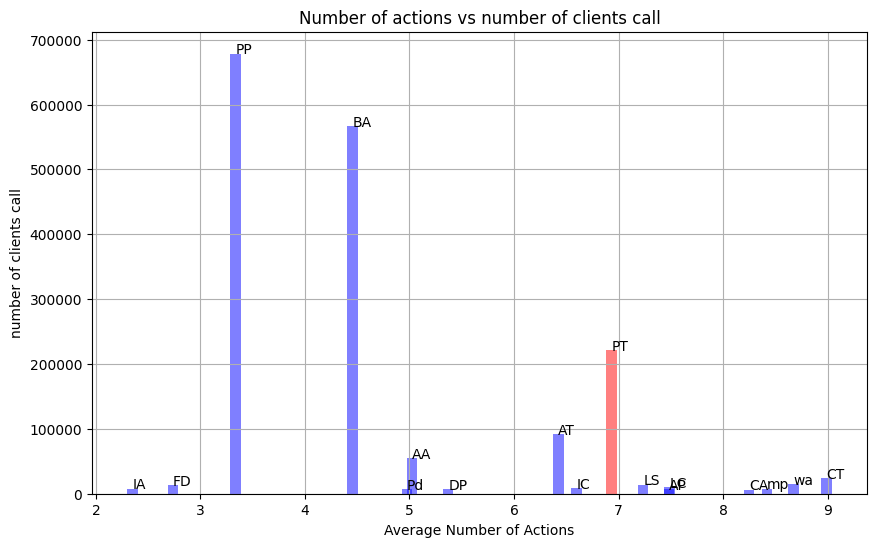

In [9]:
temp = df.groupby('reason').agg({'num_of_action':'mean','card_activation_status':'count'}).sort_values('num_of_action',ascending=False)
# Now, if you want the overall average length across all rows:
# overall_average_length = df_raw['average_length'].mean()

# print(f"The overall average length is: {temp}")
# temp[temp.card_activation_status > 1000]
temp = temp[(temp.card_activation_status > 5000)]

bar_width = 1
colors = ['red' if idx == 'PT' else 'blue' for idx in temp.index]
plt.figure(figsize=(10, 6))  # Set the figure size as desired
plt.bar(temp['num_of_action'], temp['card_activation_status'], alpha=0.5,width = 0.1,color = colors)  # alpha is set for better visibility
for idx, row in temp.iterrows():
    plt.text(row['num_of_action'], row['card_activation_status'], str(idx), fontsize=10)

plt.title('Number of actions vs number of clients call')
plt.xlabel('Average Number of Actions')
plt.ylabel('number of clients call')
plt.grid(True)
plt.show()

In [10]:
df[df.resolved == 0].combined_status.describe()

count    366217.000000
mean          0.074325
std           0.262299
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: combined_status, dtype: float64

In [11]:
df[df.reason == 'FD']

df_raw[df_raw.reason == 'FD'].account_status_13_march.unique()

temp = df.groupby('reason').agg({'resolved':'mean','card_activation_status':'count'}).sort_values('resolved',ascending=True)
# how to show after the groupby? i dont wnat to add anything, just for one group, show all the other columns
temp = temp[(temp.resolved < 0.5) & (temp.card_activation_status > 1000)].sort_values('resolved',ascending=True)
# Assuming 'temp' is your DataFrame and 'resolved' is the column with the rates
temp['resolved'] = temp['resolved'].round(3)
temp


,resolved,card_activation_status
reason,,
DP,0.015,6930
CT,0.030,23796
FD,0.041,13007
FM,0.063,4755
RV,0.070,3756
wa,0.073,14296
me,0.101,2150
eY,0.171,1192
iR,0.188,2162


Text(0, 0.5, 'Number of Actions')

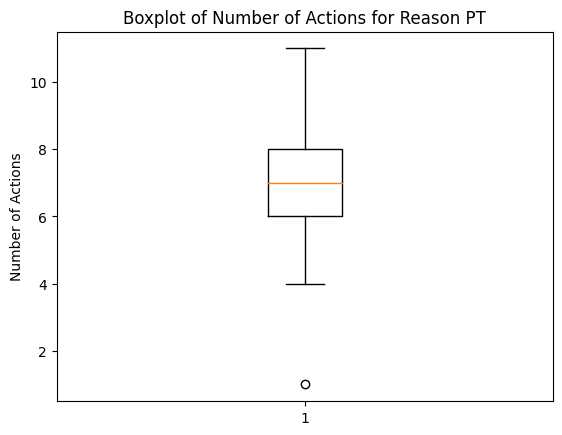

In [12]:
data = df[df['reason'] == 'PT']['num_of_action']
plt.boxplot(data)
plt.title('Boxplot of Number of Actions for Reason PT')
plt.ylabel('Number of Actions')

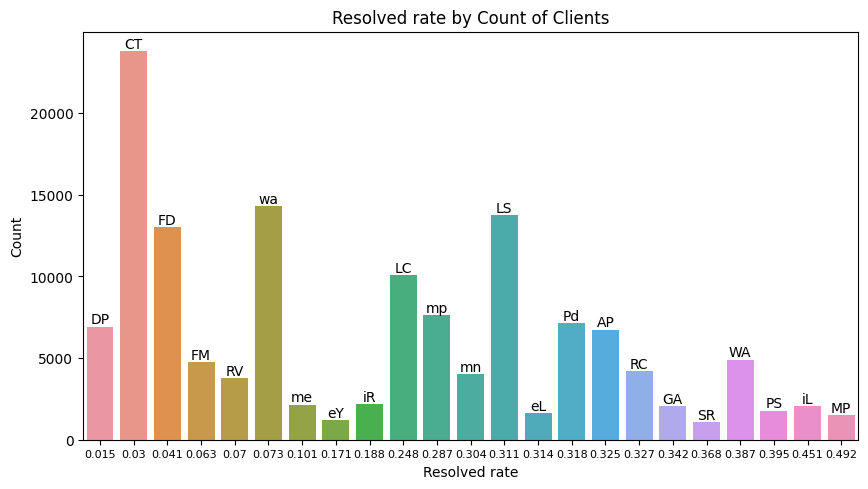

In [16]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='resolved', y='card_activation_status', data=temp)
for i, p in enumerate(barplot.patches):
    # Use the index as label if 'temp' DataFrame has 'reason' as the index
    idx_label = temp.index[i]
    # Get the height of the bar (y value) for positioning the label
    height = p.get_height()
    # Place the text label just above the bar
    plt.text(p.get_x() + p.get_width() / 2., height, str(idx_label), 
             ha='center', va='bottom', fontsize=10)
plt.title('Resolved rate by Count of Clients')
plt.xlabel('Resolved rate')
plt.ylabel('Count')
# plt.xticks(rotation=90)
# Adjust the bottom of the plotting area
plt.subplots_adjust(bottom=0.2)  # Adjust this value as needed

# Optional: Decrease font size
plt.xticks(fontsize=8)
plt.show()

In [17]:
#decision tree
import sys
import matplotlib
# matplotlib.use('Agg')

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

features = [ 'no_of_accounts',
       'account_balance', 'card_activation_status', 'eservice_ind',
       'ebill_enrolled_status', 'auto_pay_enrolled_status', 
       'account_age', 'delinquency_current', 'delinquency_prior', 'combined_status']

#how to change columns of features using loop
for feature in features:
 df[feature] = pd.to_numeric(df[feature], errors='coerce').fillna(0)


X = df[features]
y = df['resolved']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

# X_test = X_test[X_test.resolved == 1]
# y_test = y_test[y_test.resolved == 1]
y_pred = dtree.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

feature_importances = dtree.feature_importances_
sorted_feature_importances = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)

for name, importance in sorted_feature_importances:
    print(f"{name}: {importance}")

# plt.figure(figsize=(12,12))  # Set the size of the figure
# tree.plot_tree(dtree, feature_names=features, filled=True)
# plt.show()

Accuracy: 0.7162089541175598
account_age: 0.5388181729551574
account_balance: 0.29658600756340775
no_of_accounts: 0.1023564015104107
ebill_enrolled_status: 0.01581272055891906
eservice_ind: 0.010914283062139537
combined_status: 0.010150768445027401
delinquency_current: 0.009031832522207796
delinquency_prior: 0.006747798787735199
card_activation_status: 0.006029697380246219
auto_pay_enrolled_status: 0.0035523172147486053


In [18]:
df[df.reason == 'PT']

,retailer_code,reason,mos,resolved,no_of_accounts,account_balance,card_activation_status,eservice_ind,ebill_enrolled_status,auto_pay_enrolled_status,account_status_18_march,timestamp,account_age,delinquency_current,delinquency_prior,combined_status,num_of_action
2,J,PT,AA BA PT,1,12.0,0.00,8.0,0,0,0,NaN,2024-03-17 11:42:37,206192557000000000,0,0,0,7
11,E,PT,AA BA PT,1,6.0,2842.61,8.0,0,3,0,NaN,2024-03-14 12:28:55,285856135000000000,0,0,0,7
19,B,PT,PP BA AT PT,1,14.0,697.75,0.0,0,0,0,NaN,2024-03-15 13:43:04,244734184000000000,0,0,0,9
33,D,PT,BA PT,1,6.0,594.62,0.0,1,1,0,NaN,2024-03-17 16:44:19,141410659000000000,0,0,0,6
35,A,PT,BA PT,1,8.0,831.61,0.0,0,3,0,NaN,2024-03-15 17:33:09,92597589000000000,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894126,b,PT,mn BA PT,1,1.0,458.30,0.0,0,0,0,NaN,2024-03-15 21:21:42,301094502000000000,0,0,0,7
894127,p,PT,PI BA PT,1,8.0,2539.97,0.0,0,0,0,NaN,2024-03-14 08:20:53,205662053000000000,0,0,0,6
894130,f,PT,BA mp PT,1,2.0,891.93,0.0,0,0,0,E,2024-03-16 10:09:32,69242972000000000,0,0,1,6
894147,e,PT,BA SP PT,1,2.0,4066.05,0.0,0,0,0,NaN,2024-03-17 23:21:32,190941692000000000,2,0,0,8


In [19]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

features = [ 'no_of_accounts',
       'account_balance', 'card_activation_status', 'eservice_ind',
       'ebill_enrolled_status', 'auto_pay_enrolled_status', 
       'account_age', 'delinquency_current', 'delinquency_prior',
       'combined_status']

X = df[features]

y = df['resolved']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2) # 70% training and 30% test

rf = RandomForestClassifier(n_estimators=100, random_state=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

feature_importances = dtree.feature_importances_
sorted_feature_importances = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)

for name, importance in sorted_feature_importances:
    print(f"{name}: {importance}")


In [ ]:
plt.figure(figsize=(10, 6))
df.plot(kind='bar', x='resolved', y='account_age', color='skyblue')

# Adding the title and labels
plt.title('Bar Chart of Values by Category')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.xticks(rotation=0)  # Rotates X-axis labels to show them horizontally
plt.legend().set_visible(False)  # Hides the legend if not needed

# Showing the plot
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(df['resolved'], df['account_age'], alpha=0.5)

NameError: name 'plt' is not defined

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

features = [
    'no_of_accounts',
       'account_balance', 'card_activation_status', 'eservice_ind',
       'ebill_enrolled_status', 'auto_pay_enrolled_status', 
       'account_age', 'delinquency_current', 'delinquency_prior',
       'acc_status_A', 'acc_status_B', 'acc_status_C', 'acc_status_E',
       'acc_status_F', 'acc_status_I', 'acc_status_L', 'acc_status_U',
       'acc_status_Z']
target = 'resolved'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = SVC(kernel='linear', random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))